# _Dataviz Code Session_: Redes Complexas

## Objetivos da DCS

- Aplicar técnicas de dataviz para plotagem e manipulação de representações visuais de redes simples e complexas.
- Elaborar RV para dados do comércio exterior, enfatizando fluxos de importação/exportação por meio de grafos.

## Ferramentas utilizadas

- Módulos Python
    - `pandas`
    - `numpy`
    - `matplotlib`
    - `networkx`
    - `sys`

## Aplicação do modelo referencial

- Vide {numref}`Capítulo %s <cap:estetica>`.

In [1]:
from matplotlib.patches import Patch

import pandas as pd, matplotlib.pyplot as plt, seaborn as sb, numpy as np, networkx as nx
import sys; sys.path.insert(1,'../dcs')
import dcs24, dcs25

### Dados de entrada pré-processados

- Carregamento de dados

In [2]:
# carrega valores para ano y
y = 2020

# planilhas
# imp: importação; exp: exportação; cc: códigos de países/blocos; tgt_dir: diretório-fonte dos dados
imp, exp, cc, via, tgt_dir = dcs24.get_comex(y)

# remove entradas duplicadas de países
cc = cc.drop_duplicates()


COMEX files successfuly loaded from: ../data/comex-2020


#### Processamento adicional

- Fusões por código de país e meio de transporte

In [3]:
# meio de transporte
via = via.rename(columns={'Código da via':'Meio de transporte'}) 

# importação
imp = imp.rename(columns={'País de origem':'Código do país'})
imp = imp.merge(cc,on='Código do país')
imp = imp.merge(via,on='Meio de transporte')

# exportação
exp = exp.rename(columns={'País de destino':'Código do país'})
exp = exp.merge(cc,on='Código do país')
exp = exp.merge(via,on='Meio de transporte')

In [60]:
via

,Meio de transporte,Descrição da via
0,0,VIA NAO DECLARADA
1,1,MARITIMA
2,2,FLUVIAL
3,3,LACUSTRE
4,4,AEREA
5,5,POSTAL
6,6,FERROVIARIA
7,7,RODOVIARIA
8,8,CONDUTO/REDE DE TRANSMISSAO
9,9,MEIOS PROPRIOS


- Restrição de dados por escolha de via e bloco geográfico

**Nota:** execute `imp['Nome do bloco'].unique()` para a listagem de blocos.

In [61]:
# seletor de via e bloco
via_e = 'AEREA'
bloco_e = 'União Europeia - UE'

# filtros
imp_p_via = imp[(imp['Descrição da via'] == via_e) & (imp['Nome do bloco'] == bloco_e)]
exp_p_via = exp[(exp['Descrição da via'] == via_e) & (exp['Nome do bloco'] == bloco_e)]

#imp['Nome do bloco'].unique()

- Agrupamento por FOB

In [62]:
imp_p_via_e = imp_p_via.groupby('Nome do país')['Valor Free On Board'].sum()
exp_p_via_e = exp_p_via.groupby('Nome do país')['Valor Free On Board'].sum()

df_g = pd.merge(imp_p_via_e,exp_p_via_e,on='Nome do país',how='outer').reset_index()
df_g = df_g.rename(columns={'Valor Free On Board_x':'FOB_imp','Valor Free On Board_y':'FOB_exp'})


In [63]:
df_g

,Nome do país,FOB_imp,FOB_exp
0,"Aland, Ilhas",5.570000e+03,140.0
1,Alemanha,2.408373e+09,445676987.0
2,Bulgária,1.048810e+07,1095139.0
3,Bélgica,3.579592e+08,264325328.0
4,Chipre,1.090164e+06,456850.0
5,Croácia,5.911743e+06,197694.0
6,Dinamarca,2.452543e+08,17600298.0
7,Eslováquia,1.487331e+07,2123435.0
8,Eslovênia,2.733640e+07,791051.0
9,Espanha,3.249332e+08,128140171.0


## Mapeamento

- Criação de grafo para visualizar a rede de parcerias bilaterais do Brasil;
- Cada nó representa um país e cada aresta dirigida o fluxo de mercadorias;
- Para cada nó de origem $v_i$ e de destino $v_j$, a aresta $e_{ij}$ liga $v_i$ a $v_j$ nesta direção;
- Logo, fazemos o seguinte: 
    - tomando $i \in I = \{0\}$, $v_0$ passa a ser o nó correspondente ao Brasil e $e_{0j}$ são arestas de exportação;
    - $e_{j0}$ são arestas de importação;

- Separação de conjuntos para criação de lista de arestas e atributos

**Notas:** 

- Como o modelo trata-se de um _grafo dirigido_, a criação de dois conjuntos independentes é necessária para fins de visualização.
- Valores de FOB como `nan` significam que não houve fluxo entre o Brasil e o país $j$.

In [64]:
# grafo de importação
df_g_imp = pd.DataFrame({'node_from': np.arange(len(df_g))+1,
                         'node_to': [0]*len(df_g),
                         'FOB':df_g['FOB_imp'],
                         'from_name':df_g['Nome do país'],
                         'to_name':['Brasil']*len(df_g)})

# grafo de exportação
df_g_exp = pd.DataFrame({'node_to': np.arange(len(df_g))+1,
                         'node_from': [0]*len(df_g),
                         'FOB':df_g['FOB_exp'],
                         'from_name':['Brasil']*len(df_g),
                         'to_name':df_g['Nome do país']})                         

In [65]:
df_g_imp

,node_from,node_to,FOB,from_name,to_name
0,1,0,5.570000e+03,"Aland, Ilhas",Brasil
1,2,0,2.408373e+09,Alemanha,Brasil
2,3,0,1.048810e+07,Bulgária,Brasil
3,4,0,3.579592e+08,Bélgica,Brasil
4,5,0,1.090164e+06,Chipre,Brasil
5,6,0,5.911743e+06,Croácia,Brasil
6,7,0,2.452543e+08,Dinamarca,Brasil
7,8,0,1.487331e+07,Eslováquia,Brasil
8,9,0,2.733640e+07,Eslovênia,Brasil
9,10,0,3.249332e+08,Espanha,Brasil


In [66]:
df_g_exp

,node_to,node_from,FOB,from_name,to_name
0,1,0,140.0,Brasil,"Aland, Ilhas"
1,2,0,445676987.0,Brasil,Alemanha
2,3,0,1095139.0,Brasil,Bulgária
3,4,0,264325328.0,Brasil,Bélgica
4,5,0,456850.0,Brasil,Chipre
5,6,0,197694.0,Brasil,Croácia
6,7,0,17600298.0,Brasil,Dinamarca
7,8,0,2123435.0,Brasil,Eslováquia
8,9,0,791051.0,Brasil,Eslovênia
9,10,0,128140171.0,Brasil,Espanha


- Construção do grafos como objetos `Graph` do `networkx`

In [67]:
G_imp = nx.from_pandas_edgelist(df_g_imp,source='node_from',target='node_to',edge_attr='FOB')   

for index, row in df_g_imp.iterrows():
     G_imp.nodes[row['node_from']]['country'] = row['from_name']
    
G_exp = nx.from_pandas_edgelist(df_g_exp,source='node_from',target='node_to',edge_attr='FOB')   

for index, row in df_g_exp.iterrows():
     G_exp.nodes[row['node_from']]['country'] = row['from_name']    
    
# impressão auxiliar
#G_imp.nodes(data=True), G_exp.edges(data=True)

## Visualização

### Iterando em RVs primárias

- Vamos plotar os grafos de importação e exportação para a via e bloco escolhidos
    - Nós e arestas com cores padronizadas
    - Legendas por número (pouco claras)
    - Fluxo ("pesos") não especificados

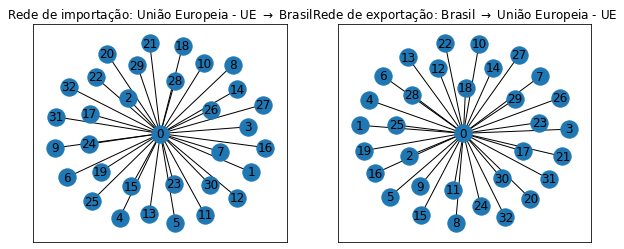

In [68]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
nx.draw_networkx(G_imp,ax=ax[0])
nx.draw_networkx(G_exp,ax=ax[1])
ax[0].set_title(f'Rede de importação: {bloco_e} $\\rightarrow$ Brasil')
ax[1].set_title(f'Rede de exportação: Brasil $\\rightarrow$ {bloco_e}');

- Controle de layout, tamanho de nós e legendas

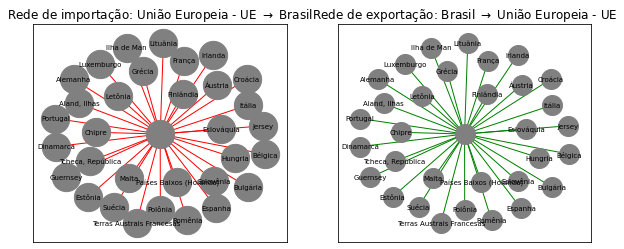

In [69]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

# controle de randomização das coordenadas dos vértices/nós
seed = 12 
coords = nx.spring_layout(G_imp,seed=seed) # layout


# --- IMPORTAÇÃO

# plotagem de nós
nx.draw_networkx_nodes(G_imp,
                       pos=coords, # controle de layout
                       node_size = 800, # tamanho do nó
                       node_color='gray', # cor do nó
                       ax=ax[0]
                       )


nx.draw_networkx_edges(G_imp,
                       pos=coords,                       
                       edge_color='red', # cor de aresta
                       ax=ax[0]
                       )


nx.draw_networkx_labels(G_imp,
                        pos=coords,
                        labels=nx.get_node_attributes(G_imp,'country'), # atributo (nome do país)
                        font_size=7, # tamanho da fonte
                        ax=ax[0],                        
                        );

ax[0].set_title(f'Rede de importação: {bloco_e} $\\rightarrow$ Brasil')


# --- EXPORTAÇÃO

# plotagem de nós
nx.draw_networkx_nodes(G_exp,
                       pos=coords, # controle de layout
                       node_size = 400, # tamanho do nó
                       node_color='gray', # cor do nó
                       ax=ax[1]
                       )


nx.draw_networkx_edges(G_exp,
                       pos=coords,                       
                       edge_color='green', # cor de aresta
                       ax=ax[1]
                       )


nx.draw_networkx_labels(G_exp,
                        pos=coords,
                        labels=nx.get_node_attributes(G_imp,'country'), # atributo (nome do país)
                        font_size=7, # tamanho da fonte
                        ax=ax[1],                        
                        )

ax[1].set_title(f'Rede de exportação: Brasil $\\rightarrow$ {bloco_e}');

- Sobrepondo os grafos

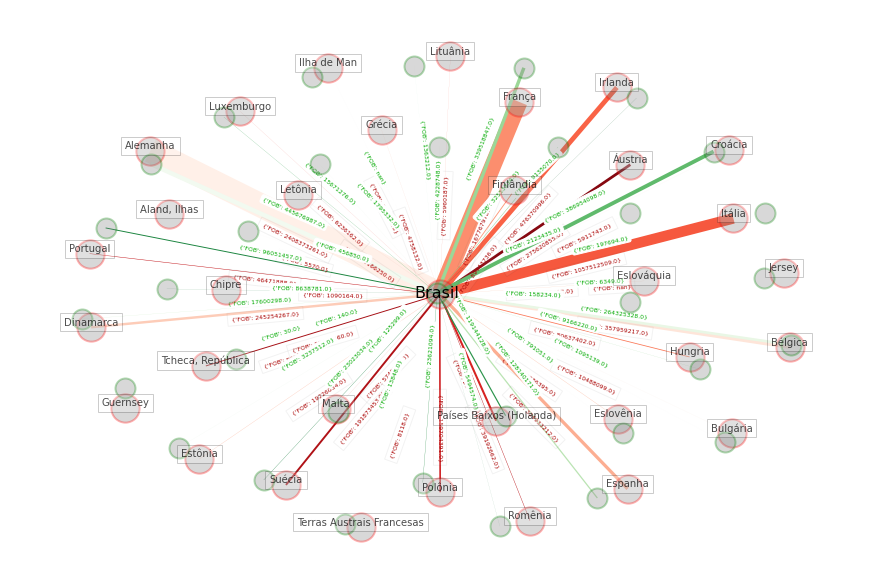

In [70]:
fig, ax = plt.subplots(figsize=(12,8),constrained_layout=True)

# --- IMPORTAÇÃO


fob, edge_colors, coords = dcs25.base_data(G_imp,fob_scale=1e8,seed=12)

cmap = plt.cm.Reds

# opções de nós
nodes = nx.draw_networkx_nodes(G_imp,
                               pos=coords,
                               node_color='grey',
                               alpha=0.3,
                               edgecolors= 'red',
                               linewidths=2,
                               node_size=800,
                               ax=ax)

# opções de arestas
edges = nx.draw_networkx_edges(G_imp,
                               pos=coords,
                               arrowstyle='->',
                               edge_color=edge_colors,
                               edge_cmap=cmap,
                               width=fob,
                               ax=ax)


# # opções de legendas de nós
labels = nx.draw_networkx_labels(G_imp,
                                 pos=coords,
                                 labels=nx.get_node_attributes(G_imp,'country'),
                                 font_color='k',
                                 alpha=0.7,
                                 verticalalignment='bottom',
                                 bbox = {'ec': 'k', 'fc': 'white', "alpha": 0.2},
                                 font_size=10,
                                 ax=ax)


edge_labels = nx.draw_networkx_edge_labels(G_imp,
                                           pos=coords,
                                           font_size=6,
                                           verticalalignment='top',
                                           bbox = {'fc': 'white', "alpha": 0.05},
                                           font_color='#aa0000')

# # --- EXPORTAÇÃO

fob, edge_colors, coords = dcs25.base_data(G_exp,fob_scale=1e8,seed=12)

cmap = plt.cm.Greens

nodes = nx.draw_networkx_nodes(G_exp,
                               pos=coords,
                               node_color='grey',
                               alpha=0.3,
                               edgecolors='green',
                               linewidths=2,
                               node_size=400,
                               ax=ax)

edges = nx.draw_networkx_edges(G_exp,
                               pos=coords,
                               arrowstyle='->',
                               edge_color=edge_colors,
                               edge_cmap=cmap,
                               width=fob,
                               ax=ax)


labels = nx.draw_networkx_labels(G_exp,
                                 pos=coords,
                                 labels=nx.get_node_attributes(G_exp,'country'),
                                 font_size=16,
                                 font_color='k')

edge_labels = nx.draw_networkx_edge_labels(G_exp,
                                           pos=coords,
                                           font_size=6,
                                           verticalalignment='bottom',
                                           font_color='#00aa00')

ax.set_axis_off()

## RV finalística

- Graph plot com adaptações
- Inclusão de legenda via patches
- Remoção do indicador FOB
    - Onde colocar?

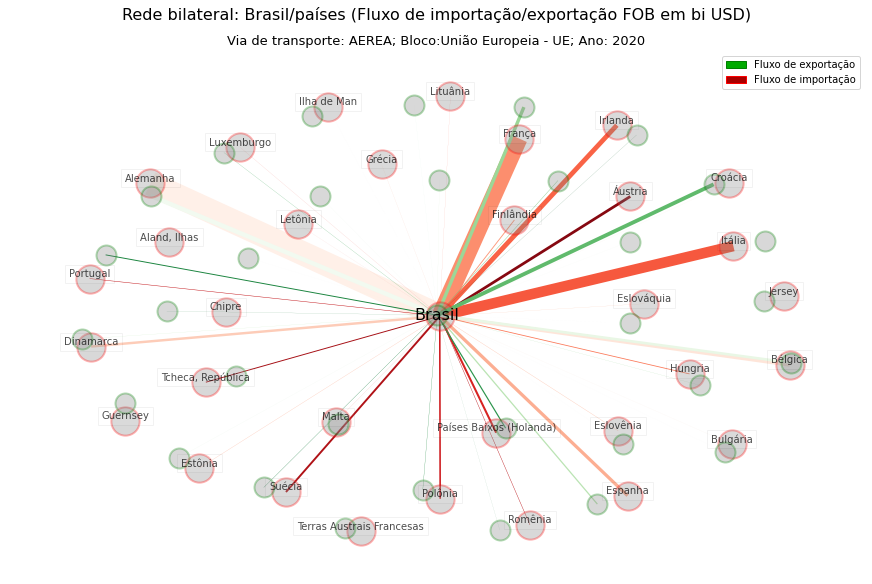

In [71]:
fig, ax = plt.subplots(figsize=(12,8),constrained_layout=True)

# --- IMPORTAÇÃO

fob, edge_colors, coords = dcs25.base_data(G_imp,fob_scale=1e8,seed=12)

cmap = plt.cm.Reds

# opções de nós
nodes = nx.draw_networkx_nodes(G_imp,
                               pos=coords,
                               node_color='grey',
                               alpha=0.3,
                               edgecolors= 'red',
                               linewidths=2,
                               node_size=800,
                               ax=ax)

# opções de arestas
edges = nx.draw_networkx_edges(G_imp,
                               pos=coords,
                               arrowstyle='->',
                               edge_color=edge_colors,
                               edge_cmap=cmap,
                               width=fob,
                               ax=ax)


# opções de legendas de nós
labels = nx.draw_networkx_labels(G_imp,
                                 pos=coords,
                                 labels=nx.get_node_attributes(G_imp,'country'),
                                 font_color='k',
                                 alpha=0.7,
                                 verticalalignment='bottom',
                                 bbox = {'ec': 'k', 'fc': 'white', "alpha": 0.05},
                                 font_size=10,
                                 ax=ax)


# edge_labels = nx.draw_networkx_edge_labels(G_imp,
#                                            pos=coords,
#                                            font_size=6,
#                                            verticalalignment='top',
#                                            bbox = {'fc': 'white', "alpha": 0.05},
#                                            font_color='#aa0000')

# --- EXPORTAÇÃO

fob, edge_colors, coords = dcs25.base_data(G_exp,fob_scale=1e8,seed=12)

cmap = plt.cm.Greens

nodes = nx.draw_networkx_nodes(G_exp,
                               pos=coords,
                               node_color='grey',
                               alpha=0.3,
                               edgecolors='green',
                               linewidths=2,
                               node_size=400,
                               ax=ax)

edges = nx.draw_networkx_edges(G_exp,
                               pos=coords,
                               arrowstyle='->',
                               edge_color=edge_colors,
                               edge_cmap=cmap,
                               width=fob,
                               ax=ax)


labels = nx.draw_networkx_labels(G_exp,
                                 pos=coords,
                                 labels=nx.get_node_attributes(G_exp,'country'),
                                 font_size=16,
                                 font_color='k')

# desativa eixos
ax.set_axis_off()

# legenda
leg = [Patch(facecolor='#00aa00', edgecolor='g', label='Fluxo de exportação'),
       Patch(facecolor='#aa0000', edgecolor='r', label='Fluxo de importação')]
ax.legend(handles=leg, loc='upper right')


# título
fig.suptitle('Rede bilateral: Brasil/países (Fluxo de importação/exportação FOB em bi USD)',fontsize=16)
ax.set_title(f'Via de transporte: {via_e}; Bloco:{bloco_e}; Ano: {y}',fontsize=13);